# **EE 488 AI Convergence Capstone Design : Anomaly Detection**
## **Assignment 1 (Reconstruction)**


In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
import matplotlib.pyplot as plt
import torchsummary
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
LATENT_DIM = 32
EPOCHS = 10
BATCH = 32
ANOMALY_NUM = 9

In [4]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_normal = [mnist_train[i][0].numpy() for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM]

train_dataset = train_normal[:-int(len(train_normal) / 10)]

train_dataset = torch.Tensor(train_dataset)

unseen_x = torch.tensor([v[0].numpy() for v in mnist_test])
unseen_y = torch.tensor([0 if v[1] != ANOMALY_NUM else 1 for v in mnist_test])

val_x = unseen_x[:int(len(unseen_x) / 2)]
val_y = unseen_y[:int(len(unseen_y) / 2)]

test_x = unseen_x[int(len(unseen_x) / 2):]
test_y = unseen_y[int(len(unseen_y) / 2):]

val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


Fill in the blank here

Model structure

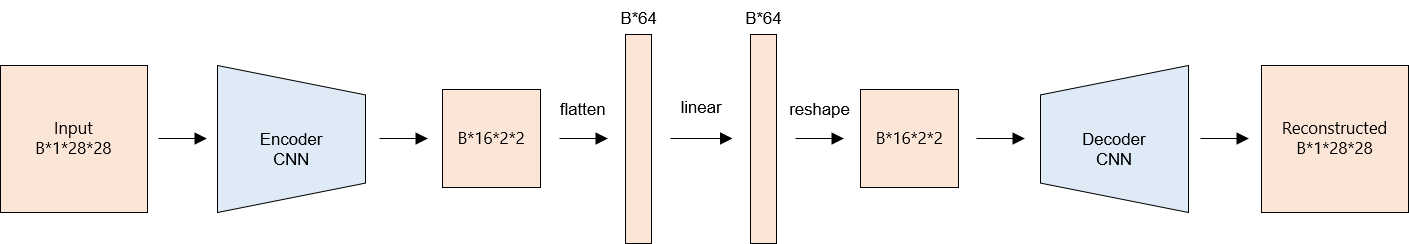

Encoder CNN

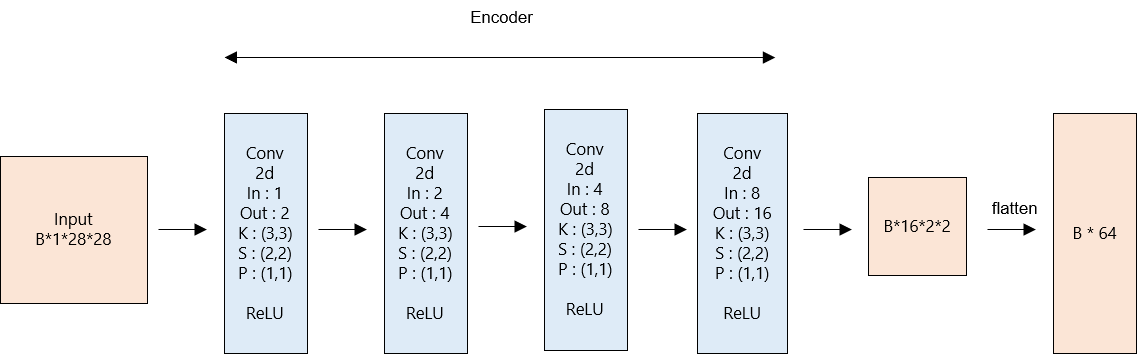

Linear

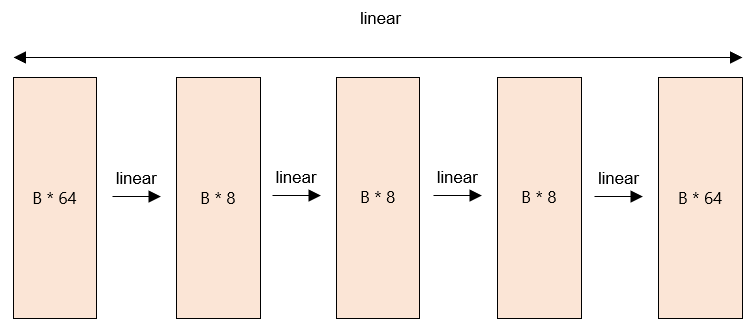

Decoder CNN

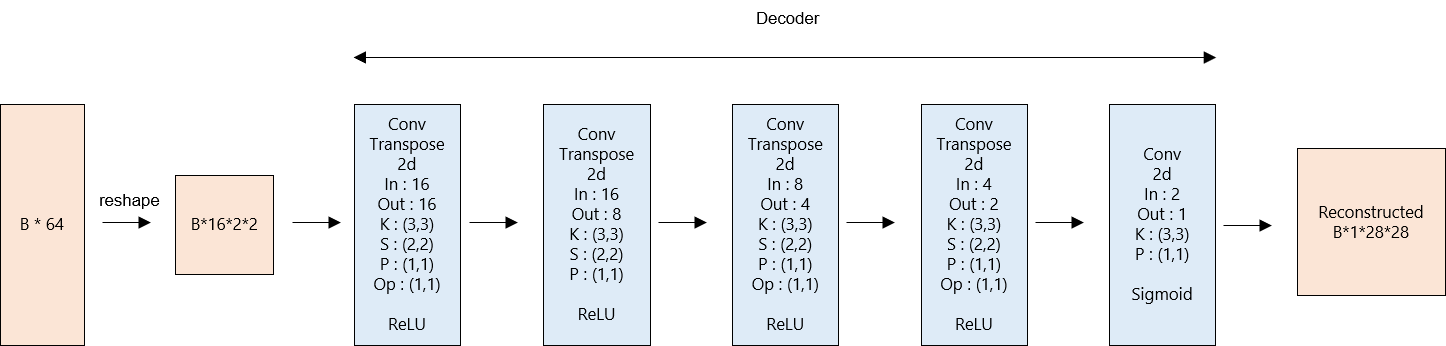

In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.ReLU())
        self.linear = nn.Sequential(
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(2, 1, kernel_size=(3, 3), padding=(1, 1)),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.encoder(x)
        output = output.view(-1,64)
        output = self.linear(output)
        output = output.view(-1, 16, 2, 2)
        output = self.decoder(output)
        return output

In [6]:
model = ConvAutoEncoder().to(device)
print(model)

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d

In [7]:
loss_fn = nn.MSELoss()
anomaly_score = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        X = X.to(device)

        pred = model(X)
        loss = loss_fn(pred, X)

        for idata in range(pred.shape[0]):

            iloss = loss_fn(pred[idata,:,:], X[idata,:,:])
            losses.append(iloss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    losses = [i.item() for i in losses]
    return np.mean(losses)

In [9]:
def test(dataloader, model, loss_fn, anomaly_score, draw_mode = False):
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    anomaly_loss = []

    with torch.no_grad():
      
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)

            for idata in range(output.shape[0]):

                loss = loss_fn(output[idata,:,:], X[idata,:,:])
                if y[idata] == 0:
                    normal_loss.append(loss)
                elif y[idata] == 1:
                    anomaly_loss.append(loss)
            
            score = torch.mean(anomaly_score(X, output), (1, 2, 3))

            y_true.extend(y.tolist())
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')


    print(f'AUC: {roc_auc:>0.3f}')
    normal_loss = [i.item() for i in normal_loss]
    anomaly_loss = [i.item() for i in anomaly_loss]
    normal_loss_mean = np.mean(normal_loss)
    anomaly_loss_mean = np.mean(anomaly_loss)
    print(f'normal loss : {normal_loss_mean}')
    print(f'anomaly loss : {anomaly_loss_mean}')
    return roc_auc.item(), normal_loss_mean, anomaly_loss_mean

In [10]:
aucs = []
train_normal_losses = []
val_normal_losses = []
val_anomaly_losses = []
best_auc = 0
best_model = model.to(device)
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_normal_loss = train(train_dataloader, model, loss_fn, optimizer)
    auc, val_normal_loss, val_anomaly_loss = test(val_dataloader, model, loss_fn, anomaly_score)
    train_normal_losses.append(train_normal_loss)
    aucs.append(auc)
    val_normal_losses.append(val_normal_loss)
    val_anomaly_losses.append(val_anomaly_loss)
    if best_auc < auc:
      best_model = model
      best_auc = auc

Epoch 1
-------------------------------
loss: 0.243415  [    0/48646]
loss: 0.067237  [ 9600/48646]
loss: 0.076914  [19200/48646]
loss: 0.067723  [28800/48646]
loss: 0.070751  [38400/48646]
loss: 0.067899  [48000/48646]
AUC: 0.454
normal loss : 0.0650074567620842
anomaly loss : 0.06145446660856788
Epoch 2
-------------------------------
loss: 0.065618  [    0/48646]
loss: 0.062593  [ 9600/48646]
loss: 0.065899  [19200/48646]
loss: 0.056562  [28800/48646]
loss: 0.058716  [38400/48646]
loss: 0.047180  [48000/48646]
AUC: 0.526
normal loss : 0.04855855561202459
anomaly loss : 0.0509872727525922
Epoch 3
-------------------------------
loss: 0.048901  [    0/48646]
loss: 0.045941  [ 9600/48646]
loss: 0.048187  [19200/48646]
loss: 0.043579  [28800/48646]
loss: 0.048723  [38400/48646]
loss: 0.039144  [48000/48646]
AUC: 0.522
normal loss : 0.04138217026660901
anomaly loss : 0.04402297843032731
Epoch 4
-------------------------------
loss: 0.040831  [    0/48646]
loss: 0.038757  [ 9600/48646]
lo

<Figure size 432x288 with 0 Axes>

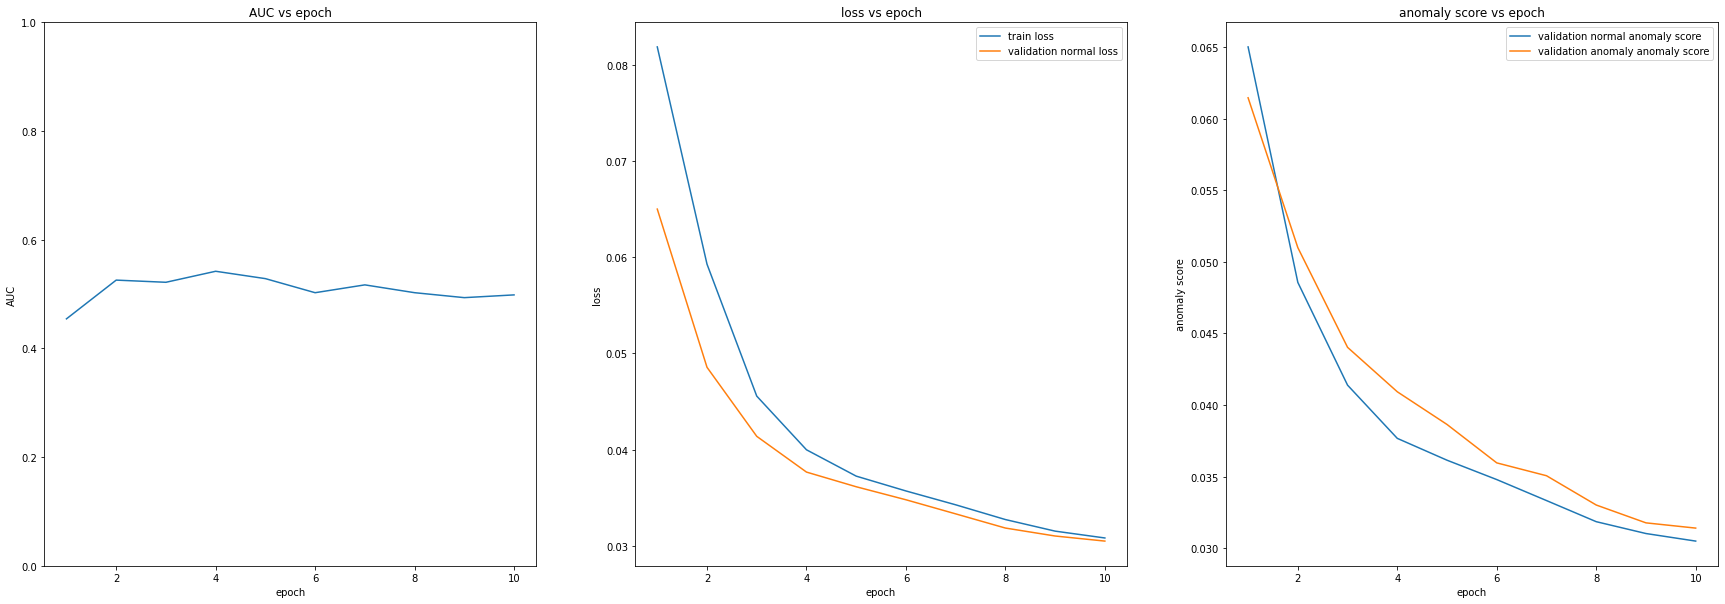

In [11]:
plt.clf()
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(aucs)+1)),aucs)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_normal_losses)+1)),train_normal_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'])

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.plot(list(range(1,len(val_anomaly_losses)+1)),val_anomaly_losses)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal anomaly score','validation anomaly anomaly score'])

AUC: 0.469
normal loss : 0.030135703773256965
anomaly loss : 0.029251815974026735


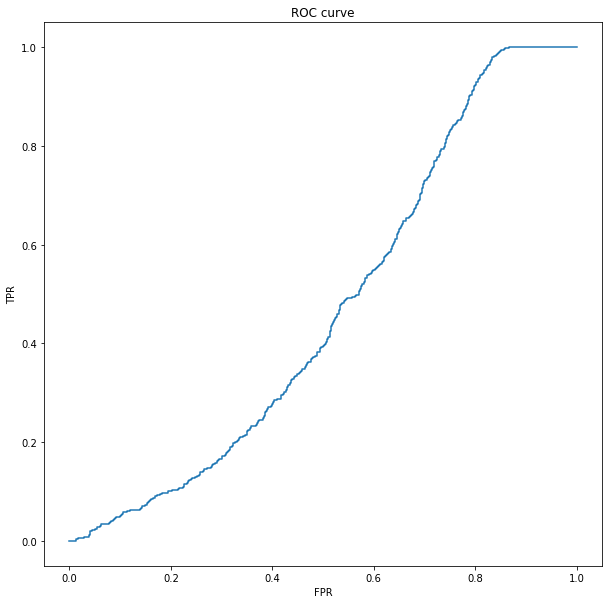

In [12]:
auc, _, _ = test(test_dataloader, best_model, loss_fn, anomaly_score, True)

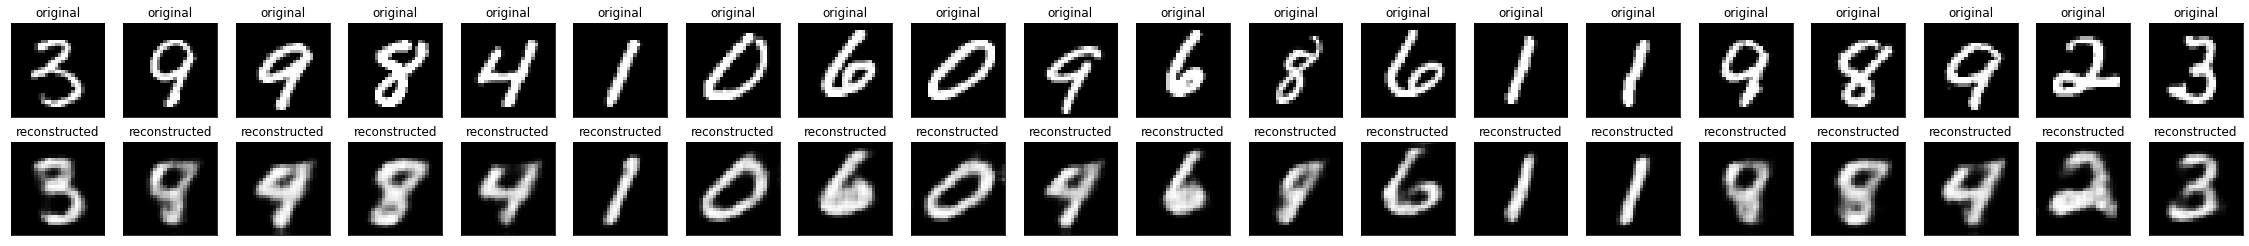

In [13]:
n = 20
plt.figure(figsize=(2*n, 4))

for i in range(n):
  input_image = test_dataset[i][0].to(device)
  output_image = best_model(input_image.unsqueeze(0))

  ax = plt.subplot(2, n, i + 1)
  plt.imshow(input_image[0].cpu())
  plt.title('original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(output_image[0].squeeze().detach().cpu())
  plt.title('reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()